# CarGuardians: Master Analysis Pipeline & Report

## 1. Executive Summary
**Objective:** Predict Air Pressure System (APS) failures in Scania trucks to minimize maintenance costs.
**Key Challenge:** The cost of a missed failure (False Negative) is 50x higher than an unnecessary check (False Positive).
**Methodology:** 
1.  **Cost-Sensitive Learning:** LightGBM with custom objective functions.
2.  **Advanced Causal Modeling:** Sparse Bayesian Networks (PyMC) to identify root causes.
3.  **The Grand Unification:** A consensus approach combining K-S Tests, SHAP values, and Lasso Regression to find the true drivers of failure.

## 2. Setup & Imports

In [1]:
import sys
import os
# Add the current directory to Python's path so it finds the 'challenge' folder
sys.path.append(os.getcwd())

In [2]:
import sys
import subprocess
import os

# --- 1. Define STRICT Stable Requirements ---
# UPDATED: Added 'sdv>=1.10.0' to fix the ModuleNotFoundError.
requirements_content = """
numpy>=1.26.0,<2.0.0
pandas>=2.2.0,<2.3.0
scipy>=1.13.0
scikit-learn>=1.5.0,<1.6.0   # CRITICAL: imblearn 0.12.x crashes with sklearn 1.6+
lightgbm>=4.3.0
imbalanced-learn>=0.12.0
xgboost>=2.0.0
catboost>=1.2.0
matplotlib>=3.8.0
seaborn>=0.13.0
networkx>=3.0
statsmodels>=0.14.0
joblib>=1.3.0
tqdm>=4.66.0
causal-learn>=0.1.3
sdv>=1.10.0                  # ADDED: Required for challenge.data.balancing

# --- CRITICAL FIXES FOR PYTHON 3.12 ---
numba>=0.59.1        # Forces pip to ignore crashing versions (0.58 and older)
shap>=0.45.0         # Newer SHAP that plays nice with new Numba
pymc>=5.16.0         # Newer PyMC that plays nice with new Numba
arviz>=0.18.0
"""

with open("requirements.txt", "w") as f:
    f.write(requirements_content)

print("✅ 'requirements.txt' updated (SDV added).")

# --- 2. Smart Installation Logic ---
def install_packages():
    print(f"🔎 Detected Python Version: {sys.version.split()[0]}")
    
    # 1. Force install the critical Numba/LLVM base first
    if sys.version_info >= (3, 12):
        print("🛡️ Locking Numba version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "numba>=0.59.1", "llvmlite>=0.42.0"])

    # 2. Install the rest
    print("⬇️ Installing missing dependencies (sdv)...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])
    
    # 3. Install local project
    print("🛠 Installing local project...")
    try:
        # Check for setup.py
        if os.path.exists("setup.py") or os.path.exists("pyproject.toml"):
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-e", "."])
        else:
            # Fallback for missing setup.py
            current_dir = os.getcwd()
            if current_dir not in sys.path:
                sys.path.append(current_dir)
            print(f"⚠️ 'setup.py' not found. Added {current_dir} to sys.path.")
            
    except subprocess.CalledProcessError:
        print("❌ Could not install local package.")

# --- 3. Execute ---
try:
    install_packages()
    print("\n🎉 Environment fixed! \nIMPORTANT: Restart the Kernel (Kernel > Restart Kernel) to load the new SDV module.")
except Exception as e:
    print(f"\n❌ Installation failed: {e}")

✅ 'requirements.txt' updated (SDV added).
🔎 Detected Python Version: 3.12.2
🛡️ Locking Numba version...


ERROR: Operation cancelled by user


KeyboardInterrupt: 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Project Imports
from challenge.data.ingest import load_data
from challenge.data.feature_selection import (
    select_features_ks, 
    select_features_mutual_info, 
    create_engineered_feature_set,
    select_top_features_rf
)
from challenge.data.outliers import fit_predict_isolation_forest, analyze_isolation_forest_outliers, visualize_outlier_rescue
from challenge.modelling.train_eval import evaluate_on_test, cv_cost
from challenge.modelling.experiment import run_experiment_grid
from challenge.modelling.models import get_models, weighted_logistic_loss, get_custom_lgbm
from challenge.modelling.selectors import ConsensusSelector
from challenge.visualization.performance_viz import plot_experiment_results, plot_confusion, plot_cost_threshold_curve

# Visualization & Analysis Imports
from challenge.visualization.eda_plots import eda_plots_with_stats
from challenge.analysis.pca_analysis import pca_inspect, inspect_pca_loadings
from challenge.visualization.feature_correlation import plot_correlation_heatmap
from challenge.data.preprocess import ScaniaPreprocessor

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Configuration
%matplotlib inline
sns.set_theme(style="whitegrid")

DATA_PATH = 'dataset/'
TRAIN_FILE = 'aps_failure_training_set.csv'
TEST_FILE = 'aps_failure_test_set.csv'


print("DEBUG: File loaded.")
from challenge.data.preprocess import ScaniaPreprocessor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
import networkx as nx
import pymc as pm
import arviz as az
# Statistical Imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import shap
from scipy.stats import ks_2samp, kurtosis, skew
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import statsmodels.api as sm
from scipy.stats import spearmanr

DEBUG: File loaded.


## 3. Data Ingestion & Initial Cleaning

We load the raw data and perform minimal cleaning (dropping low-NA rows and known outliers).

In [4]:
# 1. Load Data
X_train_raw, y_train_raw = load_data(DATA_PATH, TRAIN_FILE)
X_test_raw, y_test_raw = load_data(DATA_PATH, TEST_FILE)

print(f"Raw train shape: {X_train_raw.shape}")
print(f"Raw test shape: {X_test_raw.shape}")

Successfully loaded aps_failure_training_set.csv. X shape: (60000, 170), y shape: (60000,)
Successfully loaded aps_failure_test_set.csv. X shape: (16000, 170), y shape: (16000,)
Raw train shape: (60000, 170)
Raw test shape: (16000, 170)


In [5]:
# 2. Preprocess (Standard)
preprocessor = ScaniaPreprocessor(reduce_missingness=False)
X_clean = preprocessor.fit_transform(X_train_raw)
X_test_clean = preprocessor.transform(X_test_raw)

print(f"Preprocessed train shape: {X_clean.shape}")
print(f"Preprocessed test shape: {X_test_clean.shape}")

Preprocessing Summary:
  - Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
  - Dropping 1 constant columns: ['cd_000']
  - Retaining 162 columns.
Preprocessed train shape: (60000, 323)
Preprocessed test shape: (16000, 323)


In [6]:
# 3. Preprocess (Clustered) 
# Note: We generate this from raw first, then will filter it uniformly
preprocessor_clustering = ScaniaPreprocessor(reduce_missingness=True, cluster_threshold=0.20)
X_clean_reduced = preprocessor_clustering.fit_transform(X_train_raw)
X_test_clean_reduced = preprocessor_clustering.transform(X_test_raw)

Preprocessing Summary:
  - Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
  - Dropping 1 constant columns: ['cd_000']
  - Retaining 162 columns.
Clustering Missingness: Compressed 161 _is_missing flags into 13 modules (Threshold=0.2).


In [7]:
# 5. Feature Engineering (On Filtered Data)
X_engineered = create_engineered_feature_set(X_clean)
X_test_engineered = create_engineered_feature_set(X_test_clean)
X_engineered_reduced = create_engineered_feature_set(X_clean_reduced)
X_test_engineered_reduced = create_engineered_feature_set(X_test_clean_reduced)

Identified 7 histogram families: ['ee', 'ag', 'cn', 'ba', 'az', 'ay', 'cs']
Engineering physics features for 7 groups (Vectorized)...
Generated 49 features (Sum, Mass, Entropy, Skew, Kurt, Bimodality, Peak_Count).
Detected 7 histogram sum features. Analyzing redundancy...
Dropped 6 redundant sum features: ['ee_sum', 'cn_sum', 'ba_sum', 'az_sum', 'ay_sum', 'cs_sum']
Renamed 'ag_sum' to 'Total_Operational_Events'.
Replaced 70 raw bins with 49 physics features.
Original feature count: 323 -> New engineered feature count: 296
Identified 7 histogram families: ['ee', 'ag', 'cn', 'ba', 'az', 'ay', 'cs']
Engineering physics features for 7 groups (Vectorized)...
Generated 49 features (Sum, Mass, Entropy, Skew, Kurt, Bimodality, Peak_Count).
Detected 7 histogram sum features. Analyzing redundancy...
Dropped 6 redundant sum features: ['ee_sum', 'cn_sum', 'ba_sum', 'az_sum', 'ay_sum', 'cs_sum']
Renamed 'ag_sum' to 'Total_Operational_Events'.
Replaced 70 raw bins with 49 physics features.
Original 

In [12]:
visualize_outlier_rescue(X_clean, y_train_raw, contamination=0.005)

Generating Outlier Rescue Visualization (outlier_rescue_diagram.png)...
Saved visualization to outlier_rescue_diagram.png


In [13]:
visualize_outlier_rescue(X_clean_reduced, y_train_raw, contamination=0.003)

Generating Outlier Rescue Visualization (outlier_rescue_diagram.png)...
Saved visualization to outlier_rescue_diagram.png


In [14]:
visualize_outlier_rescue(X_engineered, y_train_raw, contamination=0.003)

Generating Outlier Rescue Visualization (outlier_rescue_diagram.png)...
Saved visualization to outlier_rescue_diagram.png


In [15]:
visualize_outlier_rescue(X_engineered_reduced, y_train_raw, contamination=0.002)

Generating Outlier Rescue Visualization (outlier_rescue_diagram.png)...
Saved visualization to outlier_rescue_diagram.png


In [34]:
# 1. Compute Feature-Specific Filtered Sets
# Clean
mask_clean = fit_predict_isolation_forest(X_clean, y=y_train_raw, contamination=0.0025)
X_clean_filtered = X_clean[mask_clean].reset_index(drop=True)
y_clean_filtered = y_train_raw[mask_clean].reset_index(drop=True)
analyze_isolation_forest_outliers(X_clean, y_train_raw, mask_clean)

# Clean Reduced
mask_reduced = fit_predict_isolation_forest(X_clean_reduced, y=y_train_raw, contamination=0.0025)
X_reduced_filtered = X_clean_reduced[mask_reduced].reset_index(drop=True)
y_reduced_filtered = y_train_raw[mask_reduced].reset_index(drop=True)
analyze_isolation_forest_outliers(X_clean_reduced, y_train_raw, mask_reduced)

mask_engineered_reduced = fit_predict_isolation_forest(X_engineered_reduced, y=y_train_raw, contamination=0.0025)
X_engineered_reduced_filtered = X_engineered_reduced[mask_engineered_reduced].reset_index(drop=True)
y_engineered_reduced_filtered = y_train_raw[mask_engineered_reduced].reset_index(drop=True)
analyze_isolation_forest_outliers(X_engineered_reduced, y_train_raw, mask_engineered_reduced)

mask_engineered = fit_predict_isolation_forest(X_engineered, y=y_train_raw, contamination=0.0025)
X_engineered_filtered = X_engineered[mask_engineered].reset_index(drop=True)
y_engineered_filtered = y_train_raw[mask_engineered].reset_index(drop=True)
analyze_isolation_forest_outliers(X_engineered, y_train_raw, mask_engineered)




--- Isolation Forest Outlier Detection (Contamination=0.0025) ---
  [IsoForest] Flagged 86 records as outliers (0.14%).
  [Safety] Rescuing 1 positive class failures from the outlier set.
  [Final] Dropping 85 outliers (Only Negatives) -> 0.14% drop rate.
  [Analysis] Dropped 85 rows.
  [Analysis] Failures inside dropped set: 0 (Failure Rate: 0.00%)
  [Analysis] Base Failure Rate of Dataset: 1.67%

--- Isolation Forest Outlier Detection (Contamination=0.0025) ---
  [IsoForest] Flagged 150 records as outliers (0.25%).
  [Safety] Rescuing 85 positive class failures from the outlier set.
  [Final] Dropping 65 outliers (Only Negatives) -> 0.11% drop rate.
  [Analysis] Dropped 65 rows.
  [Analysis] Failures inside dropped set: 0 (Failure Rate: 0.00%)
  [Analysis] Base Failure Rate of Dataset: 1.67%

--- Isolation Forest Outlier Detection (Contamination=0.0025) ---
  [IsoForest] Flagged 150 records as outliers (0.25%).
  [Safety] Rescuing 73 positive class failures from the outlier set.
  [

In [17]:
# 6. Define Feature Sets (All aligned to y_train_final)
FEATURE_SETS = {
    "Physics-Based Features": (X_engineered_filtered, X_test_engineered, y_engineered_filtered),
    "Physics-Based Features (Missingness Clustered)": (X_engineered_reduced_filtered, X_test_engineered_reduced, y_engineered_reduced_filtered),
    "Clean Features": (X_clean_filtered, X_test_clean, y_clean_filtered), 
    "Clean Features (Missingness Clustered)": (X_reduced_filtered, X_test_clean_reduced, y_reduced_filtered),
}

## 4. PCA Analysis

We start our analysis with all of the columns. 

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the data (Critical for PCA)
print("Scaling data...")
scaler = StandardScaler()
X_scaled_np = scaler.fit_transform(X_clean)

X_viz_selected = pd.DataFrame(X_scaled_np, columns=X_clean.columns, index=X_clean.index)

# 1. PCA Analysis (on selected features)
print(f"\n--- PCA Analysis (Top {(X_clean.shape[1])} Features) ---")
pca_df = pca_inspect(X_viz_selected)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_selected.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")

# Use iloc because outlier_idx is the row position from PCA, not the dataframe label

print(X_viz_selected.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_selected, component_idx=0)

In [ ]:
# 2. Correlation Heatmap (on "is_missing" features)
print(f"\n--- Correlation Heatmap (Top {X_clean.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_selected, only_missing=True) 

Our correlation table reveals the **physical architecture of the truck's sensor network**.

### 1\. The Physical Interpretation: "Module-Level Missingness"

In modern heavy trucks (like Scanias), sensors are not wired individually to the main computer. They are wired into **Electronic Control Units (ECUs)** or gathered into **wiring harnesses**.

  * **The "Power Strip" Effect:** If `ac_000`, `ae_000`, and `af_000` are 85%+ correlated in missingness, it implies they are likely plugged into the **same ECU** or share the same **power supply/data bus**.
  * **The Failure Mode:** When that specific ECU fails (or the cable is cut), *every* sensor attached to it goes `NaN` simultaneously.

Our PCA (PC1) isn't just picking up "Sensor X is broken"; it is picking up **"Subsystem Y is offline."**

### 2\. Why this matters for our Model

We have **massive multicollinearity** in your missingness flags.

  * **The Evidence:** `eg_000` and `du_000` have `0.998654` correlation.
  * **The Problem:** You currently have two features that tell the model the *exact same thing*.
      * `eg_000_is_missing = 1`
      * `du_000_is_missing = 1`
  * **The Consequence:** This dilutes feature importance. LightGBM might split on `eg` in one tree and `du` in another, making it hard to see that the **ROOT CAUSE** is the underlying module they share.

### 3\. The Solution: "Missingness Clustering"

Instead of feeding 100+ highly correlated `_is_missing` columns into your model, you should **cluster them** into "System Health" features.

Here is a strategy to reduce this noise and extract the structural signal.

#### Step A: Visualize the Clusters (The Dendrogram)

This will visually group the sensors into their physical hardware modules.


#### Step B: Feature Engineering (The Fix)

If `eg`, `du`, and `dv` are 99% correlated, replace them with a single feature called `Cluster_A_Missing`.

### 4\. Interpretation for RCA

By doing this, your Root Cause Analysis becomes much clearer:

  * **Before:** "Root cause is `eg_000_is_missing`... or maybe `du_000_is_missing`?"
  * **After:** "Root cause is `Module_4_Connectivity`."
      * You can then look up which sensors are in Module 4 and tell the mechanic: *"Check the wiring harness for the Gearbox Control Unit."*

In [ ]:
# Filter out the engineered 'is_missing' columns
physical_cols = [c for c in X_clean.columns if not c.endswith('_is_missing')]
X_physical = X_clean[physical_cols]

# Scale ONLY the physical columns
scaler = StandardScaler()
X_scaled_physical = scaler.fit_transform(X_physical)
X_viz_physical = pd.DataFrame(X_scaled_physical, columns=physical_cols, index=X_clean.index)

# Now run PCA on the physical data
print(f"\n--- PCA Analysis (Physical Sensors Only) ---")
pca_df = pca_inspect(X_viz_physical)

In [ ]:
# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_physical.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_physical.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_physical, component_idx=0)

In [ ]:
# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {X_physical.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_physical) 

In [ ]:
# Filter out the engineered 'is_missing' columns
physical_cols = [c for c in X_engineered.columns if not c.endswith('_is_missing')]
X_physical = X_engineered[physical_cols]

# Scale ONLY the physical columns
scaler = StandardScaler()
X_scaled_physical = scaler.fit_transform(X_physical)
X_viz_physical = pd.DataFrame(X_scaled_physical, columns=physical_cols, index=X_clean.index)

# Now run PCA on the physical data
print(f"\n--- PCA Analysis (Physical Sensors Only) ---")
pca_df = pca_inspect(X_viz_physical)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_physical.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_physical.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_physical, component_idx=0)

In [ ]:
# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {X_physical.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_physical) 

## 5. Clustering Analysis

In [ ]:
# Filter out the engineered 'is_missing' columns
physical_cols = [c for c in X_engineered_reduced.columns]
X_physical = X_engineered_reduced[physical_cols]

# Scale ONLY the physical columns
scaler = StandardScaler()
X_scaled_physical = scaler.fit_transform(X_physical)
X_viz_physical = pd.DataFrame(X_scaled_physical, columns=physical_cols, index=X_clean_reduced.index)

# Now run PCA on the physical data
print(f"\n--- PCA Analysis for {X_viz_physical.shape[1]} features ---")
pca_df = pca_inspect(X_viz_physical)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_physical.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_physical.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_physical, component_idx=0)


In [ ]:
# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {X_physical.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_physical) 

## 6. Model Experimentation Grid
We run a comprehensive grid search over Models, Feature Sets, and Sampling Strategies.
**Metric:** Total Cost (FP=10, FN=500).

In [20]:
#Define Feature Sets 
FEATURE_SETS = {
    #"Physics-Based Features": (X_engineered_filtered, X_test_engineered, y_engineered_filtered),
    "Physics-Based Features (Missingness Clustered)": (X_engineered_reduced_filtered, X_test_engineered_reduced, y_engineered_reduced_filtered),
    #"Clean Features": (X_clean_filtered, X_test_clean, y_clean_filtered), 
    "Clean Features (Missingness Clustered)": (X_reduced_filtered, X_test_clean_reduced, y_reduced_filtered),
}
# Define Models
MODELS = get_models(random_state=42)
MODELS = {name: model for name, model in MODELS.items() if name in ["LightGBM"]}

# Define Samplers
SAMPLERS = {
    #"No Sampling": None,
    #"SMOTE": "smote",
    "Gaussian Copula": "copula" # Uncomment to include
}

# Define Sampling Percentages
SAMPLING_PCTS = [0.25]

# Define Tuning Strategies
TUNING = {
    "Tuned Threshold": True,
    #"Fixed 0.5": False
}

SELECTORS = {
    "Consensus Selector 200": ConsensusSelector(top_n=148),
    "Consensus Selector 30": ConsensusSelector(top_n=30),
    "Consensus Selector 10": ConsensusSelector(top_n=10),
    "Consensus Selector 90": ConsensusSelector(top_n=90),
}

In [19]:
MODELS


{'LightGBM': LGBMClassifier(random_state=42, verbose=-1)}

In [17]:
# Run the Grid
results_df = run_experiment_grid(
    models=MODELS,
    feature_sets=FEATURE_SETS,
    samplers=SAMPLERS,
    tuning_strategies=TUNING,
    sampling_percentages=SAMPLING_PCTS,
    y_train=y_train_raw,  
    n_cv_splits=5, 
    verbose=True,
    selectors=SELECTORS
)

--- STARTING EXPERIMENT MATRIX ---

RUNNING: LightGBM | Physics-Based Features (Missingness Clustered) + Consensus Selector 200 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25


python(51905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51912) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Balancing: 800 minority, 47138 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...
Balancing: 800 minority, 47137 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...
Balancing: 800 minority, 47138 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...
Balancing: 800 minority, 47137 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...
Balancing: 800 minority, 47138 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58922
Balancing complete. New dataset size: 58921
Balancing complete. New dataset size: 58922
Balancing complete. New dataset size: 58921
Balancing complete. New dataset size: 58922
ConsensusSelector: Selected 148 features from 148 total.
ConsensusSelector: Selected 148 features from 148 total.
ConsensusSelector: Selected 148 features from 148 total.
ConsensusSelector: Selected 148 features from 148 total.
ConsensusSelector: Selected 148 features from 148 total.

RUNNING: LightGBM | Physics-Based Features (Missingness Clustered) + Consensus Selector 30 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preproces

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Balancing: 800 minority, 47138 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...
Balancing: 800 minority, 47137 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58922
Balancing complete. New dataset size: 58922
Balancing complete. New dataset size: 58921
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58922
Balancing complete. New dataset size: 58921
ConsensusSelector: Selected 14 features from 148 total.
ConsensusSelector: Selected 13 features from 148 total.
ConsensusSelector: Selected 14 features from 148 total.
ConsensusSelector: Selected 14 features from 148 total.
ConsensusSelector: Selected 15 features from 148 total.

RUNNING: LightGBM | Physics-Based Features (Missingness Clustered) + Consensus Selector 10 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing 

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Preprocessing Summary:
  - Retaining 148 columns.
Balancing complete. New dataset size: 58921
Balancing complete. New dataset size: 58922
Balancing complete. New dataset size: 58922
Balancing: 800 minority, 47137 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...
Balancing complete. New dataset size: 58922


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58921
ConsensusSelector: Selected 4 features from 148 total.
ConsensusSelector: Selected 3 features from 148 total.
ConsensusSelector: Selected 3 features from 148 total.
ConsensusSelector: Selected 4 features from 148 total.
ConsensusSelector: Selected 3 features from 148 total.

RUNNING: LightGBM | Physics-Based Features (Missingness Clustered) + Consensus Selector 90 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Balancing: 800 minority, 47138 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...
Balancing: 800 minority, 47138 majority.
Target ratio: 0.25 -> Target minority count: 1

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58922
Balancing complete. New dataset size: 58922
Balancing complete. New dataset size: 58922
Balancing complete. New dataset size: 58921
Balancing complete. New dataset size: 58921
ConsensusSelector: Selected 97 features from 148 total.
ConsensusSelector: Selected 98 features from 148 total.
ConsensusSelector: Selected 97 features from 148 total.
ConsensusSelector: Selected 95 features from 148 total.
ConsensusSelector: Selected 95 features from 148 total.

RUNNING: LightGBM | Clean Features (Missingness Clustered) + Consensus Selector 200 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Summary

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58928
Balancing complete. New dataset size: 58927
Balancing complete. New dataset size: 58927
Balancing complete. New dataset size: 58928
Balancing complete. New dataset size: 58927
ConsensusSelector: Selected 175 features from 175 total.
ConsensusSelector: Selected 175 features from 175 total.
ConsensusSelector: Selected 175 features from 175 total.
ConsensusSelector: Selected 175 features from 175 total.
ConsensusSelector: Selected 175 features from 175 total.

RUNNING: LightGBM | Clean Features (Missingness Clustered) + Consensus Selector 30 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Sum

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing: 800 minority, 47142 majority.
Target ratio: 0.25 -> Target minority count: 11785
Synthesizing 10985 samples...
Balancing: 800 minority, 47143 majority.
Target ratio: 0.25 -> Target minority count: 11785
Synthesizing 10985 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58928
Balancing complete. New dataset size: 58927
Balancing complete. New dataset size: 58927
Balancing complete. New dataset size: 58928
Balancing complete. New dataset size: 58927
ConsensusSelector: Selected 15 features from 175 total.
ConsensusSelector: Selected 13 features from 175 total.
ConsensusSelector: Selected 13 features from 175 total.
ConsensusSelector: Selected 13 features from 175 total.
ConsensusSelector: Selected 14 features from 175 total.

RUNNING: LightGBM | Clean Features (Missingness Clustered) + Consensus Selector 10 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Summary:

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58927
Balancing complete. New dataset size: 58927
Balancing complete. New dataset size: 58928
Balancing complete. New dataset size: 58928
Balancing complete. New dataset size: 58927
ConsensusSelector: Selected 1 features from 175 total.
ConsensusSelector: Selected 4 features from 175 total.
ConsensusSelector: Selected 2 features from 175 total.
ConsensusSelector: Selected 3 features from 175 total.
ConsensusSelector: Selected 4 features from 175 total.

RUNNING: LightGBM | Clean Features (Missingness Clustered) + Consensus Selector 90 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Summary:
  - 

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58928
Balancing complete. New dataset size: 58928
Balancing complete. New dataset size: 58927
Balancing complete. New dataset size: 58927
Balancing complete. New dataset size: 58927
ConsensusSelector: Selected 93 features from 175 total.
ConsensusSelector: Selected 90 features from 175 total.
ConsensusSelector: Selected 94 features from 175 total.
ConsensusSelector: Selected 91 features from 175 total.
ConsensusSelector: Selected 92 features from 175 total.

--- EXPERIMENT MATRIX COMPLETE ---


## 7. Experiment Results & Best Model Selection

,model,feature_set,selector,sampler,tuning,cost_mean,cost_std,auc_mean,f1_mean,fit_time_mean,run_name,sampling_percentage
4,LightGBM,Clean Features (Missingness Clustered),Consensus Selector 200,Gaussian Copula,Tuned Threshold,7270.0,1295.144780,0.990170,0.776006,31.195790,LightGBM | Clean Features (Missingness Cluster...,0.25
0,LightGBM,Physics-Based Features (Missingness Clustered),Consensus Selector 200,Gaussian Copula,Tuned Threshold,7512.0,1157.262287,0.989111,0.760207,22.911946,LightGBM | Physics-Based Features (Missingness...,0.25
7,LightGBM,Clean Features (Missingness Clustered),Consensus Selector 90,Gaussian Copula,Tuned Threshold,7784.0,870.898387,0.988526,0.741009,23.919112,LightGBM | Clean Features (Missingness Cluster...,0.25
3,LightGBM,Physics-Based Features (Missingness Clustered),Consensus Selector 90,Gaussian Copula,Tuned Threshold,7848.0,628.916529,0.989150,0.770097,21.779301,LightGBM | Physics-Based Features (Missingness...,0.25
5,LightGBM,Clean Features (Missingness Clustered),Consensus Selector 30,Gaussian Copula,Tuned Threshold,9256.0,1739.512575,0.984938,0.718844,25.050926,LightGBM | Clean Features (Missingness Cluster...,0.25
1,LightGBM,Physics-Based Features (Missingness Clustered),Consensus Selector 30,Gaussian Copula,Tuned Threshold,10162.0,1270.329091,0.985762,0.699932,18.332429,LightGBM | Physics-Based Features (Missingness...,0.25
6,LightGBM,Clean Features (Missingness Clustered),Consensus Selector 10,Gaussian Copula,Tuned Threshold,12170.0,2469.809709,0.976344,0.686626,23.088096,LightGBM | Clean Features (Missingness Cluster...,0.25
2,LightGBM,Physics-Based Features (Missingness Clustered),Consensus Selector 10,Gaussian Copula,Tuned Threshold,39406.0,24931.350224,0.858449,0.566241,17.175239,LightGBM | Physics-Based Features (Missingness...,0.25


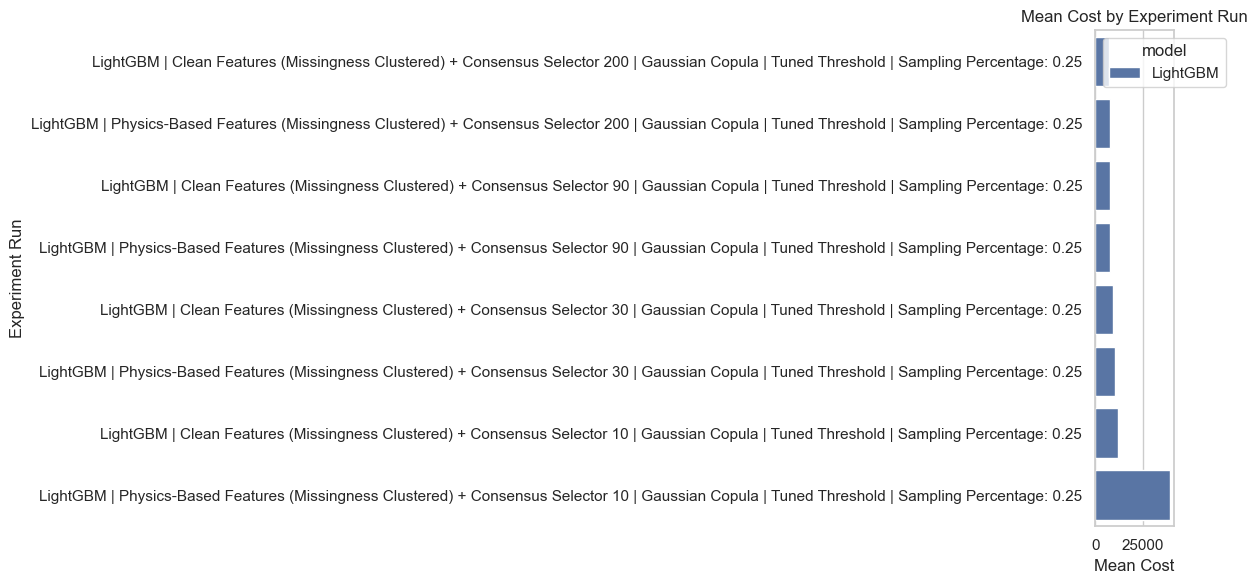

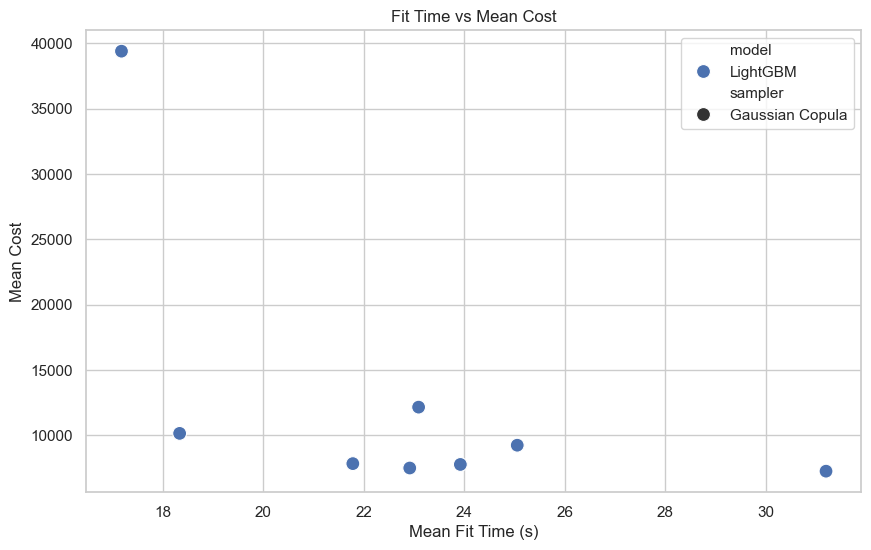

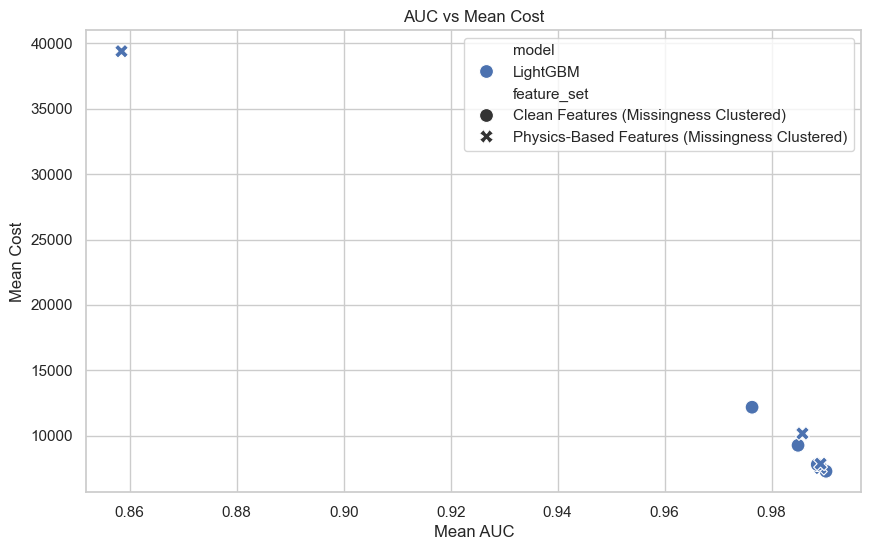

In [18]:
# Display Top Results
display(results_df.sort_values(by='cost_mean').head(80))

# Visualize Results
plot_experiment_results(results_df.sort_values(by='cost_mean').head(80))

--- EVALUATING TOP MODELS ON TEST SET (Fixed Pipeline) ---

No: 1 Run: LightGBM | Clean Features (Missingness Clustered) + Consensus Selector 200 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Summary:
  - Retaining 175 columns.
Balancing: 800 minority, 47142 majority.
Target ratio: 0.25 -> Target minority count: 11785
Synthesizing 10985 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58927
ConsensusSelector: Selected 175 features from 175 total.
Preprocessing Summary:
  - Retaining 175 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58928 majority.
Target ratio: 0.25 -> Target minority count: 14732
Synthesizing 13732 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 73660
ConsensusSelector: Selected 175 features from 175 total.
--> Visualizing Rank 1


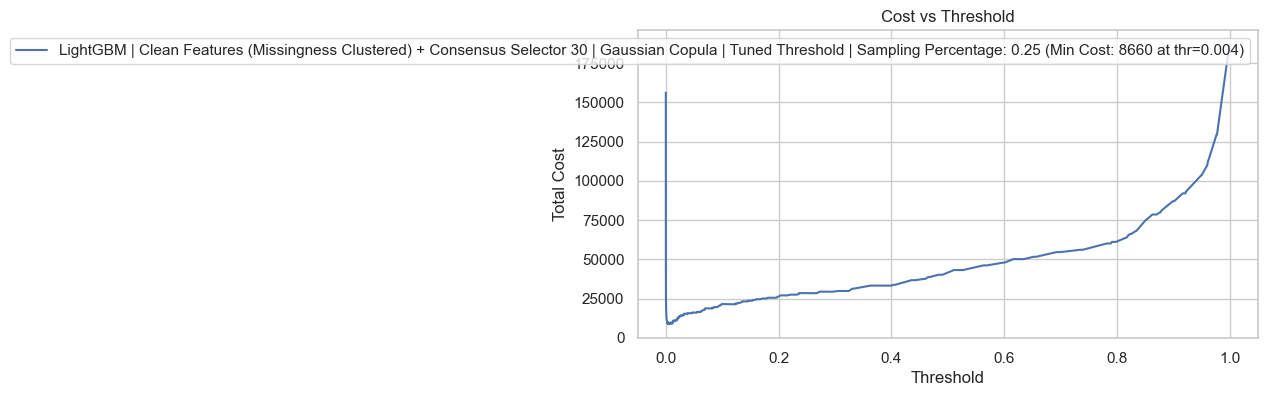

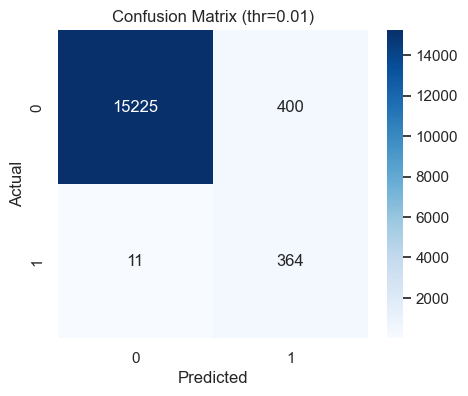


No: 2 Run: LightGBM | Physics-Based Features (Missingness Clustered) + Consensus Selector 200 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Summary:
  - Retaining 148 columns.
Balancing: 800 minority, 47137 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58921
ConsensusSelector: Selected 148 features from 148 total.
Preprocessing Summary:
  - Retaining 148 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58922 majority.
Target ratio: 0.25 -> Target minority count: 14730
Synthesizing 13730 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 73652
ConsensusSelector: Selected 148 features from 148 total.
--> Visualizing Rank 2


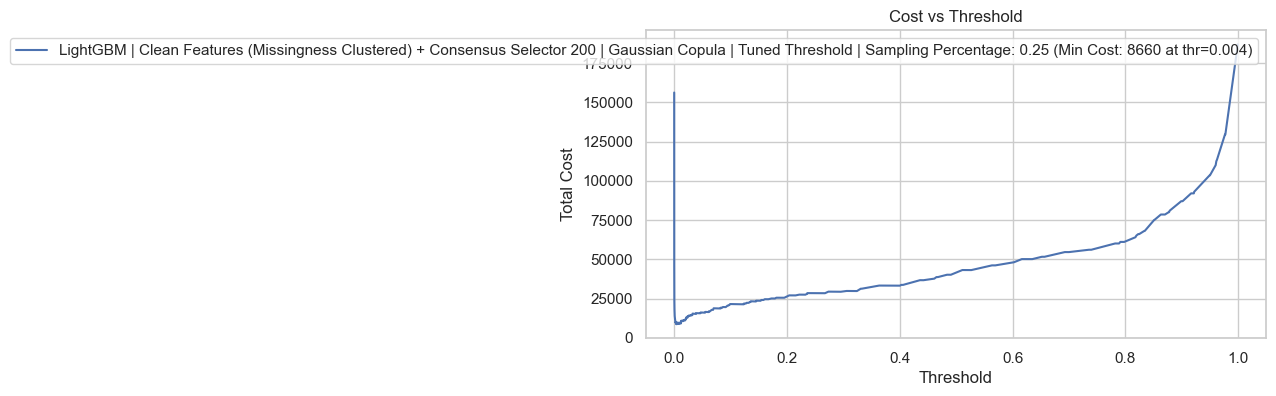

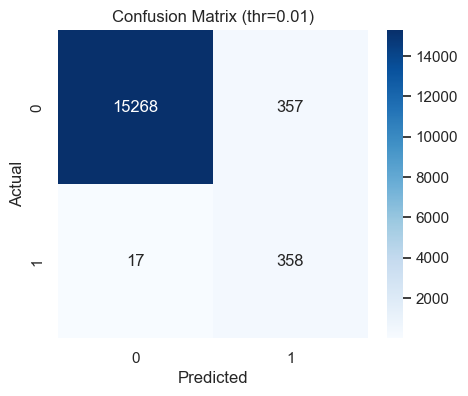


No: 3 Run: LightGBM | Clean Features (Missingness Clustered) + Consensus Selector 90 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Summary:
  - Retaining 175 columns.
Balancing: 800 minority, 47142 majority.
Target ratio: 0.25 -> Target minority count: 11785
Synthesizing 10985 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58927
ConsensusSelector: Selected 88 features from 175 total.
Preprocessing Summary:
  - Retaining 175 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58928 majority.
Target ratio: 0.25 -> Target minority count: 14732
Synthesizing 13732 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 73660
ConsensusSelector: Selected 90 features from 175 total.
--> Visualizing Rank 3


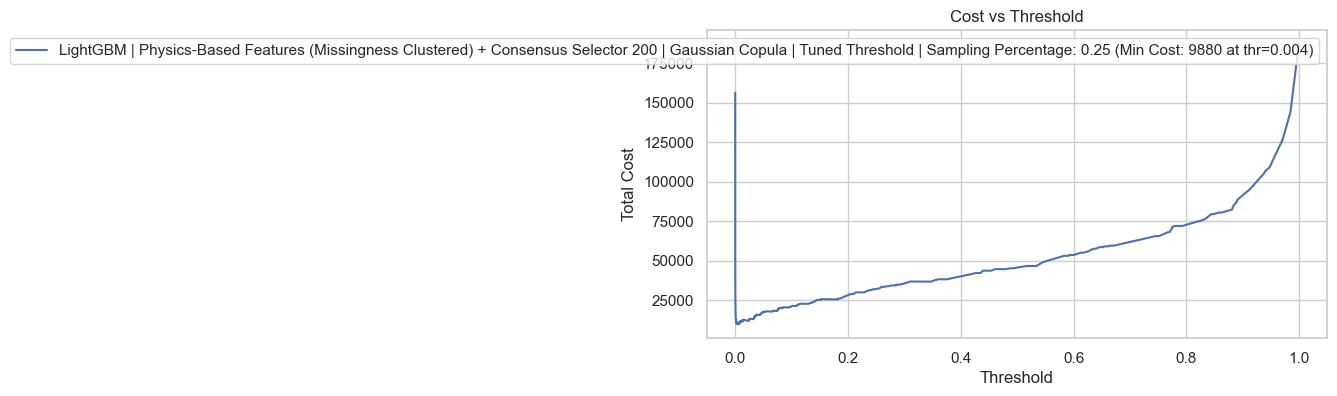

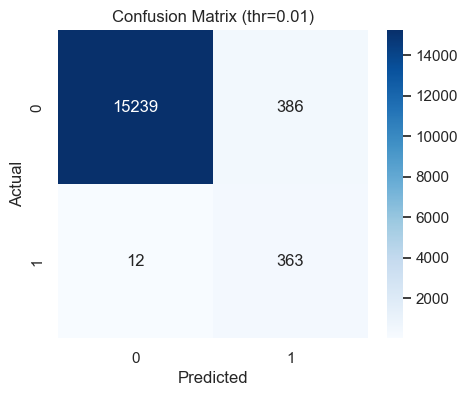


No: 4 Run: LightGBM | Physics-Based Features (Missingness Clustered) + Consensus Selector 90 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Summary:
  - Retaining 148 columns.
Balancing: 800 minority, 47137 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58921
ConsensusSelector: Selected 95 features from 148 total.
Preprocessing Summary:
  - Retaining 148 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58922 majority.
Target ratio: 0.25 -> Target minority count: 14730
Synthesizing 13730 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 73652
ConsensusSelector: Selected 96 features from 148 total.
--> Visualizing Rank 4


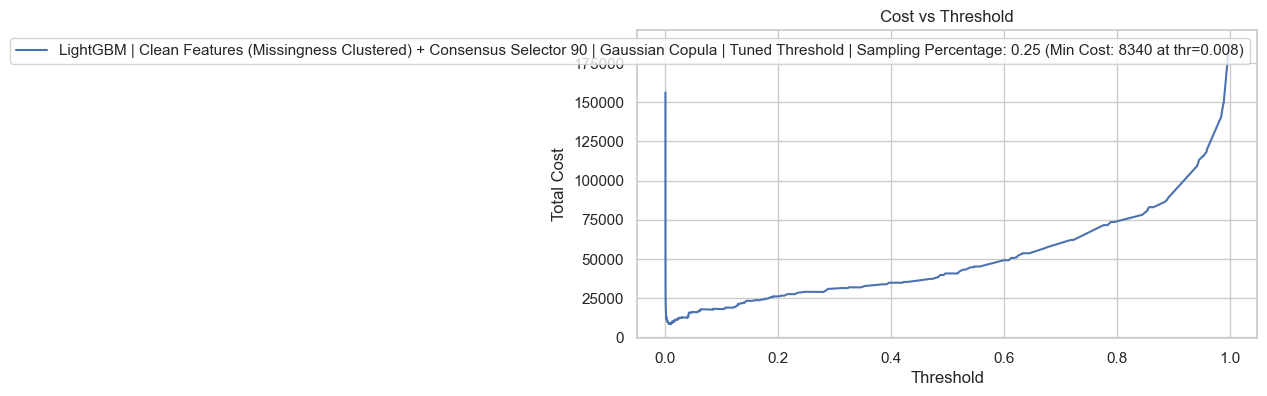

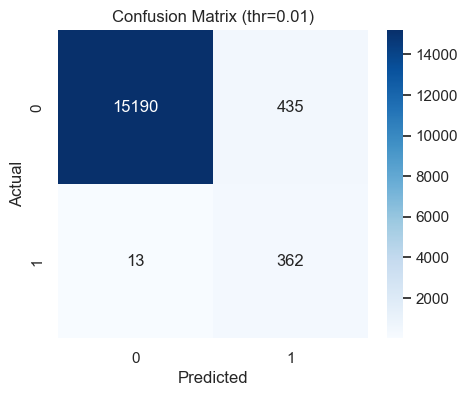


No: 5 Run: LightGBM | Clean Features (Missingness Clustered) + Consensus Selector 30 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Summary:
  - Retaining 175 columns.
Balancing: 800 minority, 47142 majority.
Target ratio: 0.25 -> Target minority count: 11785
Synthesizing 10985 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58927
ConsensusSelector: Selected 14 features from 175 total.
Preprocessing Summary:
  - Retaining 175 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58928 majority.
Target ratio: 0.25 -> Target minority count: 14732
Synthesizing 13732 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 73660
ConsensusSelector: Selected 14 features from 175 total.
--> Visualizing Rank 5


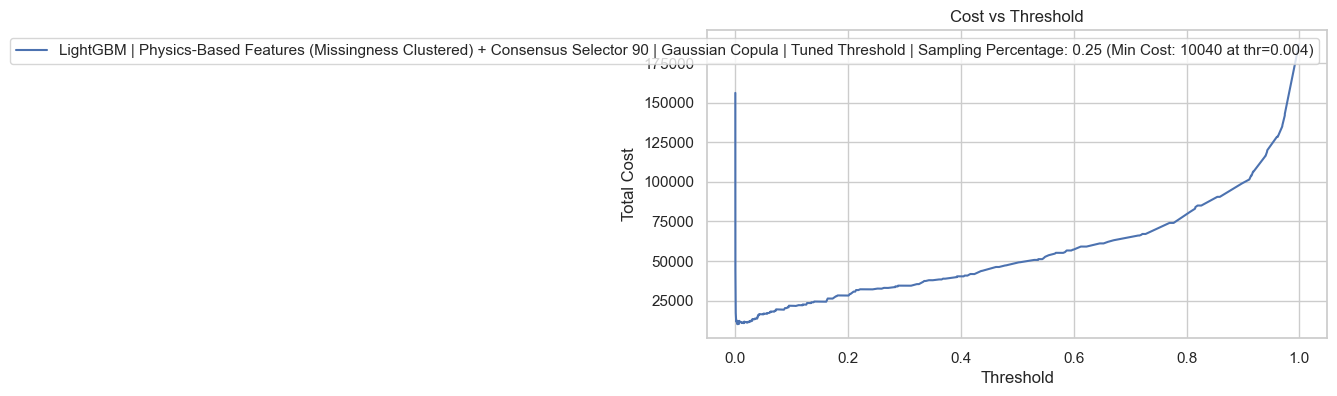

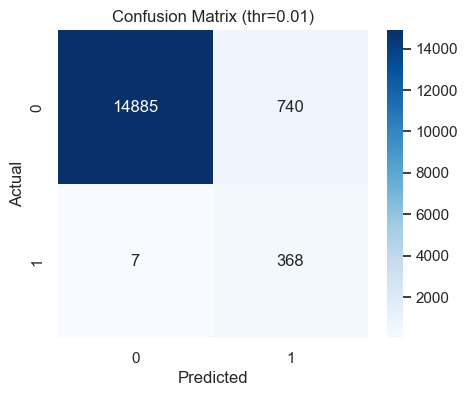


No: 6 Run: LightGBM | Physics-Based Features (Missingness Clustered) + Consensus Selector 30 | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Preprocessing Summary:
  - Retaining 148 columns.
Balancing: 800 minority, 47137 majority.
Target ratio: 0.25 -> Target minority count: 11784
Synthesizing 10984 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58921
ConsensusSelector: Selected 15 features from 148 total.
Preprocessing Summary:
  - Retaining 148 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58922 majority.
Target ratio: 0.25 -> Target minority count: 14730
Synthesizing 13730 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 73652
ConsensusSelector: Selected 13 features from 148 total.

No: 7 Run: LightGBM | Clean Features (Missingness Clustered) + Consensus Selector 10 | Gaussian Copula | Tuned Threshold | Sampl

,model,feature_set,selector,sampler,tuning,cost_mean,cost_std,auc_mean,f1_mean,fit_time_mean,run_name,sampling_percentage
0,LightGBM,Clean Features (Missingness Clustered),Consensus Selector 200,Gaussian Copula,Tuned Threshold,9500.0,0.0,0.995818,0.812920,14.449118,LightGBM | Clean Features (Missingness Cluster...,0.25
2,LightGBM,Clean Features (Missingness Clustered),Consensus Selector 90,Gaussian Copula,Tuned Threshold,9860.0,0.0,0.995631,0.816509,14.522450,LightGBM | Clean Features (Missingness Cluster...,0.25
3,LightGBM,Physics-Based Features (Missingness Clustered),Consensus Selector 90,Gaussian Copula,Tuned Threshold,10850.0,0.0,0.993977,0.801608,12.609956,LightGBM | Physics-Based Features (Missingness...,0.25
4,LightGBM,Clean Features (Missingness Clustered),Consensus Selector 30,Gaussian Copula,Tuned Threshold,10900.0,0.0,0.990069,0.735907,14.228090,LightGBM | Clean Features (Missingness Cluster...,0.25
1,LightGBM,Physics-Based Features (Missingness Clustered),Consensus Selector 200,Gaussian Copula,Tuned Threshold,12070.0,0.0,0.993862,0.822391,12.843115,LightGBM | Physics-Based Features (Missingness...,0.25
6,LightGBM,Clean Features (Missingness Clustered),Consensus Selector 10,Gaussian Copula,Tuned Threshold,14720.0,0.0,0.981877,0.696990,13.796626,LightGBM | Clean Features (Missingness Cluster...,0.25
5,LightGBM,Physics-Based Features (Missingness Clustered),Consensus Selector 30,Gaussian Copula,Tuned Threshold,17360.0,0.0,0.988156,0.793372,12.087735,LightGBM | Physics-Based Features (Missingness...,0.25
7,LightGBM,Physics-Based Features (Missingness Clustered),Consensus Selector 10,Gaussian Copula,Tuned Threshold,103470.0,0.0,0.773839,0.567687,12.048575,LightGBM | Physics-Based Features (Missingness...,0.25


In [20]:
from sklearn.pipeline import Pipeline
from copy import deepcopy

# 1. Container for Test Results
test_results_list = []

print("--- EVALUATING TOP MODELS ON TEST SET (Fixed Pipeline) ---")

# Iterate through top 20 models
top_n = min(20, len(results_df)) 

for i in range(top_n):
    if not results_df.empty:
        best_run = results_df.sort_values(by='cost_mean').iloc[i]
        print(f"\nNo: {i+1} Run: {best_run['run_name']}")
        
        # Configuration
        model_name = best_run['model']
        model_obj = MODELS[model_name]
        
        # --- FIX: Reconstruct Pipeline with Selector ---
        selector_name = best_run['selector']
        selector_obj = SELECTORS.get(selector_name)
        
        if selector_obj is not None:
            # Create a pipeline: Selector -> Model
            pipe_steps = [
                ('selector', deepcopy(selector_obj)),
                ('model', deepcopy(model_obj))
            ]
            model_to_run = Pipeline(pipe_steps)
        else:
            model_to_run = deepcopy(model_obj)
        # ---------------------------------------------

        fset_name = best_run['feature_set']
        
        # Robust Feature Unpacking
        feature_data = FEATURE_SETS[fset_name]
        if isinstance(feature_data, tuple):
            if len(feature_data) == 3:
                X_tr, X_te, y_tr_specific = feature_data
            elif len(feature_data) == 2:
                X_tr, X_te = feature_data
                y_tr_specific = y_train_raw 
            else:
                 raise ValueError(f"Unexpected tuple length for feature set {fset_name}")
        else:
             X_tr = feature_data
             X_te = None
             y_tr_specific = y_train_raw

        sampler_name = best_run['sampler']
        sampler_key = SAMPLERS.get(sampler_name) 
        
        best_pct = best_run.get('sampling_percentage')
        if pd.isna(best_pct):
            best_pct = 'auto'
        
        # Evaluate
        test_results = evaluate_on_test(
            model=model_to_run, # Passing the Pipeline now
            X_train=X_tr, 
            y_train=y_tr_specific,
            X_test=X_te,
            y_test=y_test_raw, 
            sampler=sampler_key,
            sampling_strategy=best_pct,
            max_threshold=0.4, 
            tune_if_none=True,
            verbose=False 
        )
        
        # Store Result
        metrics = test_results['metrics']
        test_entry = {
            'model': model_name,
            'feature_set': fset_name,
            'selector': selector_name,
            'sampler': sampler_name,
            'tuning': "Tuned Threshold", 
            'cost_mean': metrics['Cost'],       
            'cost_std': 0.0,
            'auc_mean': metrics['AUC'],
            'f1_mean': metrics['MacroF1'],
            'fit_time_mean': metrics['fit_time'],
            'run_name': best_run['run_name'],
            'sampling_percentage': best_pct if best_pct != 'auto' else float('nan')
        }
        test_results_list.append(test_entry)
        
        # Viz for Top 5
        if i < 5:
            print(f"--> Visualizing Rank {i+1}")
            probs = test_results['test_probabilities']
            plot_confusion(y_test_raw, probs, threshold=test_results['metrics']['Threshold'])
            plot_cost_threshold_curve(y_test_raw, probs, label=best_run['run_name'])

# Create Final DataFrame
results_test_df = pd.DataFrame(test_results_list)

print("\n--- Final Test Set Results (Corrected) ---")
display(results_test_df.sort_values(by='cost_mean'))

## 8. Root Cause Analysis (RCA)

### **1. Core Concept: SHAP Values**

SHAP (SHapley Additive exPlanations) values measure the impact of each feature on a specific prediction.

  - **Base Value ($E[f(x)]$):** The average prediction of the model across the training dataset.
  - **SHAP Value ($\phi$):** How much a specific feature pushes the prediction away from the base value.
  - **Equation:** `Prediction = Base Value + Sum(SHAP Values)`

### **2. Choosing the Right Explainer**

The type of model you are using determines which SHAP explainer is most efficient.

| Model Type | Recommended Explainer | Why? |
| :--- | :--- | :--- |
| **Tree-based** (XGBoost, LightGBM, Random Forest, CatBoost) | `shap.TreeExplainer` | Optimized for trees; extremely fast and accurate. |
| **Deep Learning** (TensorFlow, PyTorch) | `shap.DeepExplainer` | Approximates SHAP values for neural networks. |
| **Model-Agnostic** (Any model, e.g., SVM, KNN) | `shap.KernelExplainer` | Works for any model but is computationally expensive (slow). |
| **Automatic Selection** | `shap.Explainer` | Automatically chooses the best explainer based on the model passed. |


### **4. Key Visualization Interpretations**

#### **A. Waterfall Plot (`shap.plots.waterfall`)**

**Use for:** Explaining **one specific prediction**.

  - **X-axis:** The prediction value (e.g., probability or regression score).
  - **Y-axis:** Features contributing to this specific result.
  - **Red bars:** Pushed the prediction **higher**.
  - **Blue bars:** Pushed the prediction **lower**.
  - **Interpretation:** Starts at the bottom with the average prediction (base value) and adds/subtracts values to reach the final prediction at the top.

#### **B. Beeswarm Plot (`shap.plots.beeswarm`)**

**Use for:** Global feature importance and understanding feature effects across the **whole dataset**.

  - **Y-axis:** Features ordered by importance (top is most important).
  - **X-axis:** SHAP value (impact on model output).
  - **Color:** Feature value (Red = High, Blue = Low).
  - **Interpretation:**
      - If "Age" has **red dots on the right**, it means **higher age** leads to a **higher prediction**.
      - If "Income" has **blue dots on the right**, it means **lower income** leads to a **higher prediction**.


#### **C. Force Plot (`shap.plots.force`)**

**Use for:** Interactive visualization for single or multiple predictions.

  - Similar to the waterfall plot but condensed into a single horizontal bar.
  - Useful for stacking multiple predictions to see trends over a dataset (e.g., how explanations change over time).


#### **D. Bar Plot (`shap.plots.bar`)**

**Use for:** Simple global feature importance.

  - Shows the average absolute SHAP value for each feature.
  - Tells you **which** features matter most, but not **how** (unlike the beeswarm plot).


### **5. Important Notes**

  - **Data for `shap_values`:** When calculating SHAP values, you usually pass the **test set** or a sample of it, not the training set, to understand how the model generalizes.
  - **Interaction Values:** SHAP can also calculate interaction values to show how two features combined affect the prediction, distinct from their individual effects.

In [21]:
# 3. RCA Deep Dive: Best Run per Target Feature Set
print("\n" + "="*80)
print("RCA DEEP DIVE: Best Performing Models for Target Feature Sets")
print("="*80)


RCA DEEP DIVE: Best Performing Models for Target Feature Sets


In [22]:
import os
from challenge.rca.pipeline import run_rca_pipeline
# 1. Setup Output Directory
output_base_dir = os.path.abspath(os.path.join(os.getcwd(), 'results', 'rca_results'))
os.makedirs(output_base_dir, exist_ok=True)
print(f"RCA Results will be saved to: {output_base_dir}")

for fset_target in target_rca_sets:
    # Filter for this feature set
    subset = results_df[results_df['feature_set'] == fset_target]
    
    if not subset.empty:
        # Get best run (lowest cost)
        best_run = subset.sort_values(by='cost_mean').iloc[0]
        run_name = best_run['run_name']
        print(f"\n>>> Processing Best Run for: {fset_target}")
        print(f">>> Run Name: {run_name}")
        
        # Unique prefix for this run's artifacts
        # sanitize name for filesystem
        safe_name = run_name.replace(" ", "_").replace("(", "").replace(")", "")
        file_prefix = f"{safe_name}_"
        
        # Re-evaluate to get fitted objects
        model = MODELS[best_run['model']]
        X_tr, X_te = FEATURE_SETS[fset_target]
        sampler_key = SAMPLERS[best_run['sampler']]
        best_pct = best_run.get('sampling_percentage', 'auto')
        
        test_results = evaluate_on_test(
            model=model,
            X_train=X_tr,
            y_train=y_train_raw,
            X_test=X_te,
            y_test=y_test_raw,
            sampler=sampler_key,
            sampling_strategy=best_pct if sampler_key else 'auto',
            tune_if_none=True,
            verbose=True
        )
        
        # --- RCA Execution ---
        print(f"\n[RCA] Launching Pipeline for {run_name}...")
        
        # Correctly grab the fitted model from results
        fitted_model = test_results['model']
        
        # Reprocess Data correctly
        prep = test_results['preprocessor']
        scaler = test_results['scaler']
        
        # Transform X_train to match what model sees
        X_imp = prep.transform(X_tr)
        X_sc = scaler.transform(X_imp)
        
        if hasattr(X_imp, 'columns'):
            X_dim_fixed = pd.DataFrame(X_sc, columns=X_imp.columns, index=X_imp.index)
        else:
            cols = getattr(X_tr, "columns", [f"feat_{i}" for i in range(X_sc.shape[1])])
            X_dim_fixed = pd.DataFrame(X_sc, columns=cols)
            
        Y_fixed = y_train_raw
        # Run RCA with Output controls
        run_rca_pipeline(
            fitted_model, 
            X_dim_fixed, 
            Y_fixed, 
            output_dir=output_base_dir,
            file_prefix=file_prefix
        )
        print(f"[RCA] Completed for {fset_target}.\n")
        print("-" * 40)
    else:
        print(f"\n[Warning] No runs found for feature set: {fset_target}")

RCA Results will be saved to: /Users/berkcalisir/School&Career/school-docs/Challenge@Stellantis/Challenge-Stellantis---CarGuardians/src/results/rca_results


NameError: name 'target_rca_sets' is not defined

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

def analyze_feature_relationships(X, y, reference_col, families=None):
    """
    Analyzes the relationship of a reference column against cumulative feature 
    families and the target class, using Log-Scale for density plots.
    """
    if families is None:
        families = ['ag', 'ay', 'ba', 'cn', 'cs', 'ee']
        
    print(f"\n=== Analysis for Reference Column: {reference_col} ===")

    # --- TEST 1: Family Correlations & Scatter Plots ---
    n_families = len(families)
    n_cols = 3
    n_rows = (n_families + n_cols - 1) // n_cols
    
    plt.figure(figsize=(5 * n_cols, 5 * n_rows))
    
    for i, family in enumerate(families):
        # Get all columns for this family
        cols = [c for c in X.columns if c.startswith(family + '_') and c[-1].isdigit()]
        
        if not cols: 
            continue
        
        # Calculate Sum of the family for each truck
        family_sum = X[cols].sum(axis=1)
        
        # Calculate Correlation with reference_col
        corr, _ = spearmanr(X[reference_col], family_sum, nan_policy='omit')
        
        # Plot
        plt.subplot(n_rows, n_cols, i+1)
        plt.scatter(X[reference_col], family_sum, alpha=0.1, s=1)
        plt.title(f"{reference_col} vs Sum({family}_*)\nSpearman Corr: {corr:.4f}")
        plt.xlabel(reference_col)
        plt.ylabel(f"Total Events ({family})")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- TEST 2: The "Correlation King" Test ---
    print(f"\n--- Top 10 Features Correlated with {reference_col} ---")
    correlations = X.corrwith(X[reference_col], method='spearman').abs()
    print(correlations.sort_values(ascending=False).head(11))

    # --- TEST 3: The "Wear-Out" Test (Log Scale Fix) ---
    print(f"\n--- Class Distribution by {reference_col} (Log1p Transformed) ---")
    plt.figure(figsize=(10, 6))
    
    # Combine for plotting
    data_plot = pd.concat([X[reference_col], y.rename('class')], axis=1)
    
    # APPLY LOG TRANSFORMATION HERE
    # np.log1p(x) = log(x + 1). This effectively shows order-of-magnitude differences
    sns.kdeplot(x=np.log1p(data_plot[reference_col]), 
                hue=data_plot['class'], 
                common_norm=False, 
                fill=True)
    
    plt.title(f"Distribution of Log1p({reference_col}): Healthy (0) vs Failure (1)")
    plt.xlabel(f"Log1p({reference_col}) value")
    plt.show()

    # Check descriptive stats
    print("\nDescriptive Stats (Original Scale):")
    print(X[reference_col].groupby(y).describe())

In [23]:
def classify_and_analyze_features(X, features=None, families=None):
    """
    Classifies features into 'Global Usage', 'Secondary Usage', or 'Diagnostic'
    based on their Spearman correlation with cumulative feature family sums.
    
    Args:
        X (pd.DataFrame): Feature matrix.
        features (list): List of column names to classify.
        families (list): Feature families to aggregate (default: ['ag', 'ay', 'ba', 'cn', 'cs', 'ee']).
    """
    if families is None:
        families = ['ag', 'ay', 'ba', 'cn', 'cs', 'ee']
        
    if features is None:
        # Default list from request, removing duplicates
        features = list(set([
            'bi_000', 'dx_000', 'ao_000', 'cu_000', 'cb_000', 'bk_000', 
            'cv_000', 'bj_000', 'bc_000', 'dn_000', 'ap_000', 'ai_000', 
            'cj_000', 'aq_000', 'bi_000', 'an_000', 'bs_000', 'aa_000', 
            'am_0', 'bb_000', 'bk_000'
        ]))

    results = []

    print(f"{'Feature':<10} | {'Avg Corr':<10} | {'Classification'}")
    print("-" * 45)

    for col in features:
        if col not in X.columns:
            print(f"{col:<10} | {'N/A':<10} | Not found in DataFrame")
            continue

        corrs = []
        for family in families:
            # Sum family columns
            family_cols = [c for c in X.columns if c.startswith(family + '_') and c[-1].isdigit()]
            if not family_cols:
                continue
                
            family_sum = X[family_cols].sum(axis=1)
            
            # Calculate Correlation (omitting NaNs)
            corr, _ = spearmanr(X[col], family_sum, nan_policy='omit')
            if not np.isnan(corr):
                corrs.append(abs(corr)) # Use absolute correlation

        if not corrs:
            print(f"{col:<10} | {'NaN':<10} | No valid family correlations")
            continue

        # Metric: Average correlation across all families
        avg_corr = np.mean(corrs)
        
        # Classification Logic
        if avg_corr > 0.85:
            classification = "Global Usage (Proxy for Age)"
        elif 0.50 <= avg_corr <= 0.85:
            classification = "Secondary Usage (Duty Cycle)"
        else:
            classification = "Diagnostic / Specific Signal"

        results.append({
            'Feature': col,
            'Avg_Corr': avg_corr,
            'Classification': classification
        })
        
        print(f"{col:<10} | {avg_corr:.4f}     | {classification}")

    return pd.DataFrame(results).sort_values(by='Avg_Corr', ascending=False)

In [24]:
# Load raw data
X_train_raw, y_train_raw = load_data(DATA_PATH, TRAIN_FILE)
X_test_raw, y_test_raw = load_data(DATA_PATH, TEST_FILE)

print(f"Raw train shape: {X_train_raw.shape}")
print(f"Raw test shape: {X_test_raw.shape}")

Successfully loaded aps_failure_training_set.csv. X shape: (60000, 170), y shape: (60000,)
Successfully loaded aps_failure_test_set.csv. X shape: (16000, 170), y shape: (16000,)
Raw train shape: (60000, 170)
Raw test shape: (16000, 170)


In [25]:
y_train_raw.value_counts()

class
0    59000
1     1000
Name: count, dtype: int64

In [26]:
# 2. Preprocess (Standard)
preprocessor = ScaniaPreprocessor(reduce_missingness=False)
X_clean = preprocessor.fit_transform(X_train_raw)
X_test_clean = preprocessor.transform(X_test_raw)

print(f"Preprocessed train shape: {X_clean.shape}")
print(f"Preprocessed test shape: {X_test_clean.shape}")

Preprocessing Summary:
  - Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
  - Dropping 1 constant columns: ['cd_000']
  - Retaining 162 columns.
Preprocessed train shape: (60000, 323)
Preprocessed test shape: (16000, 323)


In [21]:
# Usage Example:
classification_df = classify_and_analyze_features(X_train_raw)

NameError: name 'classify_and_analyze_features' is not defined


=== Analysis for Reference Column: ci_000 ===


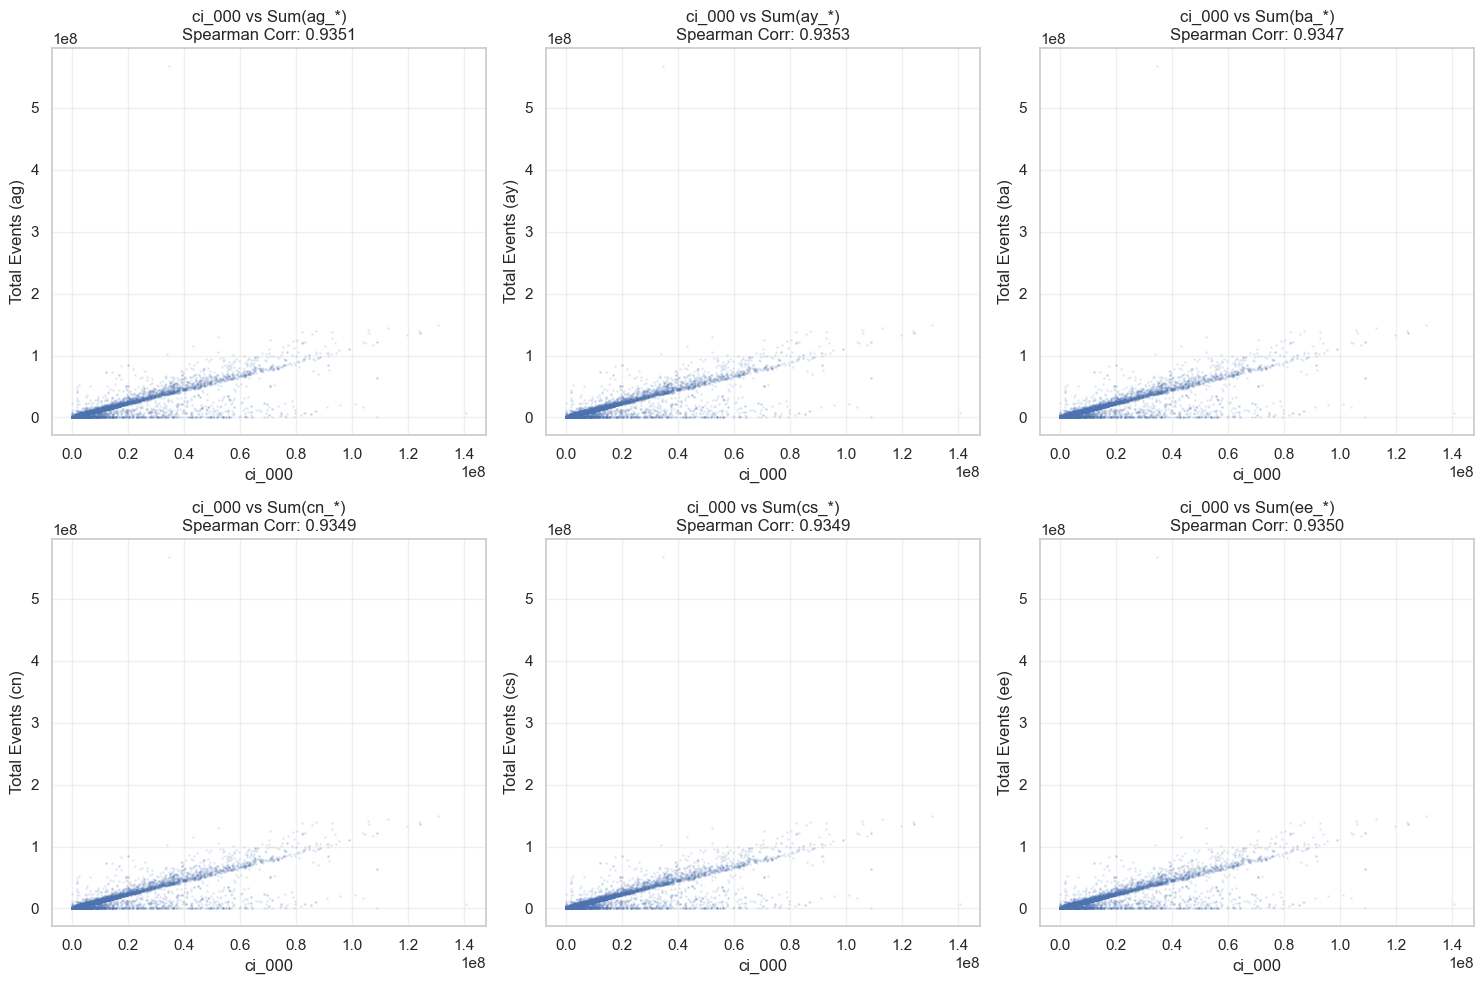


--- Top 10 Features Correlated with ci_000 ---
ci_000    1.000000
bt_000    0.980255
aa_000    0.977641
bg_000    0.975166
ah_000    0.975020
an_000    0.974514
bb_000    0.971416
cq_000    0.970860
bu_000    0.970860
bv_000    0.970860
ao_000    0.969644
dtype: float64

--- Class Distribution by ci_000 (Log1p Transformed) ---


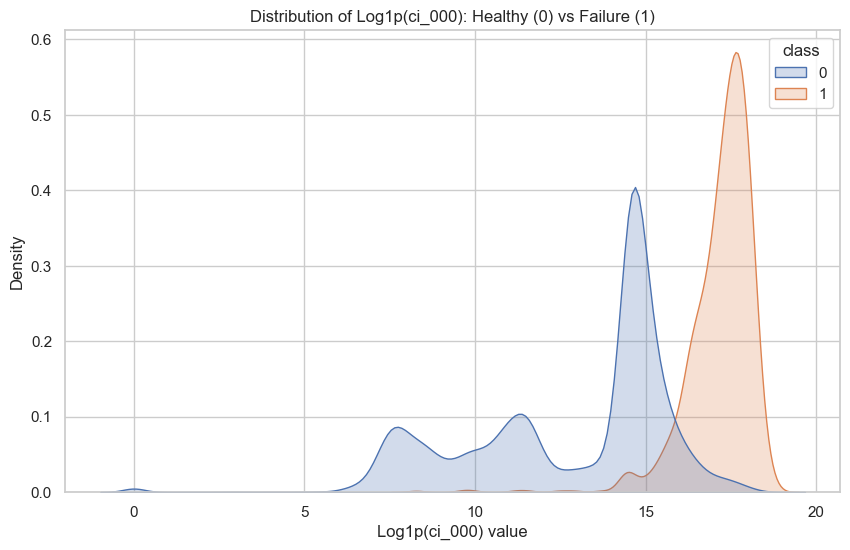


Descriptive Stats (Original Scale):
         count          mean           std      min          25%          50%  \
class                                                                           
0      58915.0  2.876169e+06  6.305064e+06     0.00     46038.24   1831898.88   
1       1000.0  3.870163e+07  2.372318e+07  3915.84  19768277.52  35874037.92   

               75%           max  
class                             
0       2822621.28  1.308788e+08  
1      54275865.84  1.409861e+08  


In [35]:
analyze_feature_relationships(X_clean_filtered, y_clean_filtered, "ci_000")


=== Analysis for Reference Column: ag_002 ===


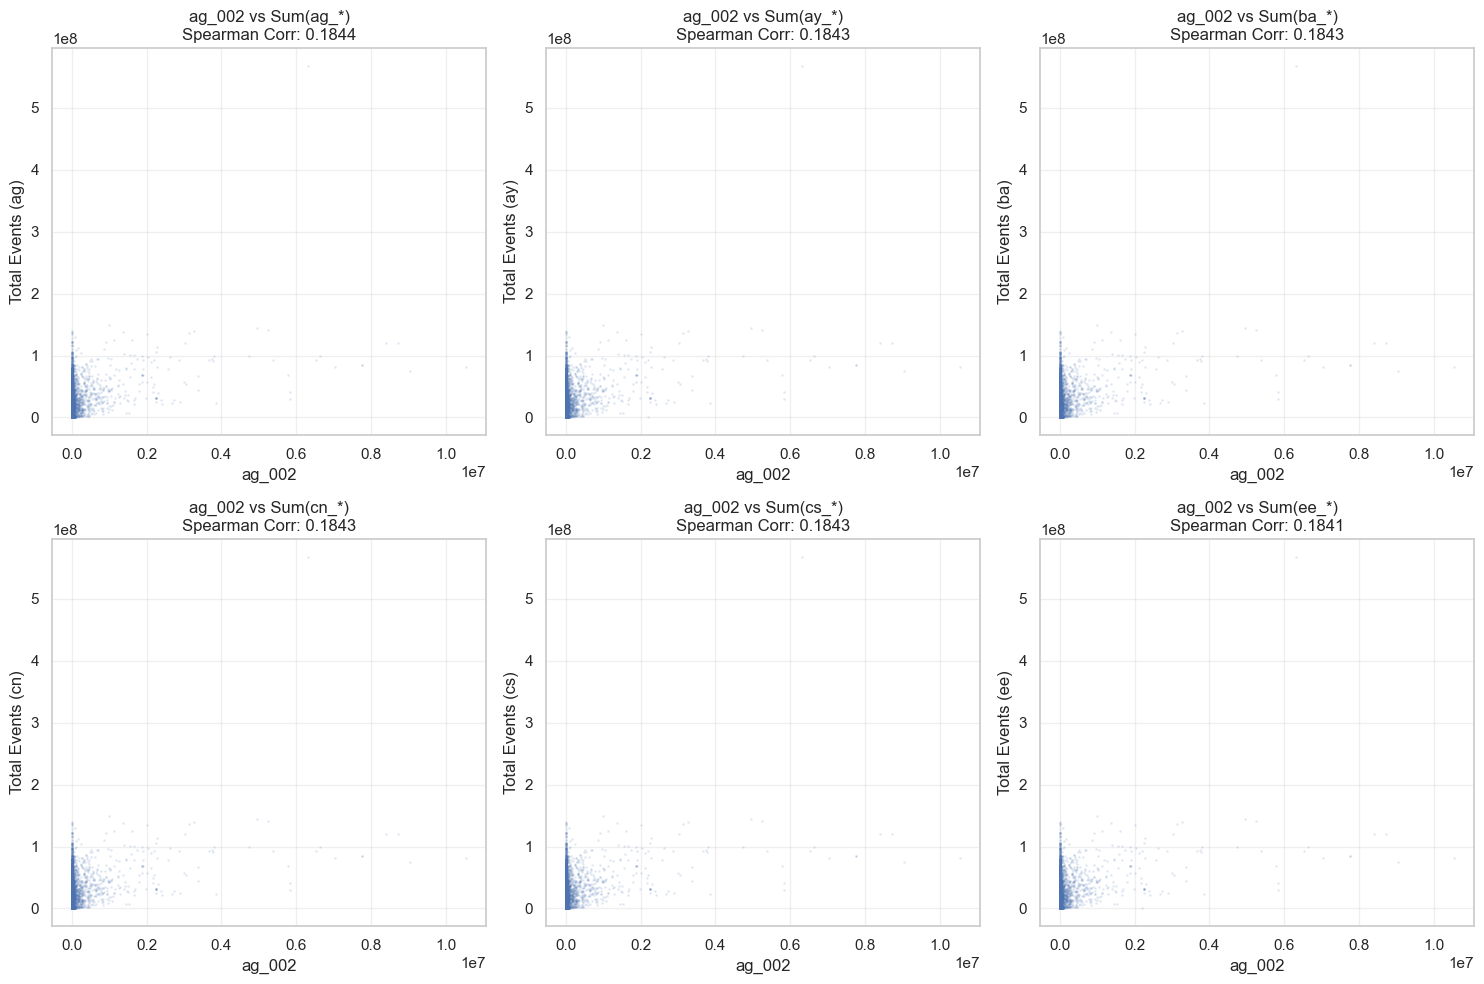


--- Top 10 Features Correlated with ag_002 ---
ag_002    1.000000
cn_000    0.780029
cn_001    0.595755
ag_003    0.524767
ag_001    0.490023
al_000    0.386120
am_0      0.386045
cn_002    0.370639
ar_000    0.355256
ba_009    0.325730
ag_004    0.318753
dtype: float64

--- Class Distribution by ag_002 (Log1p Transformed) ---


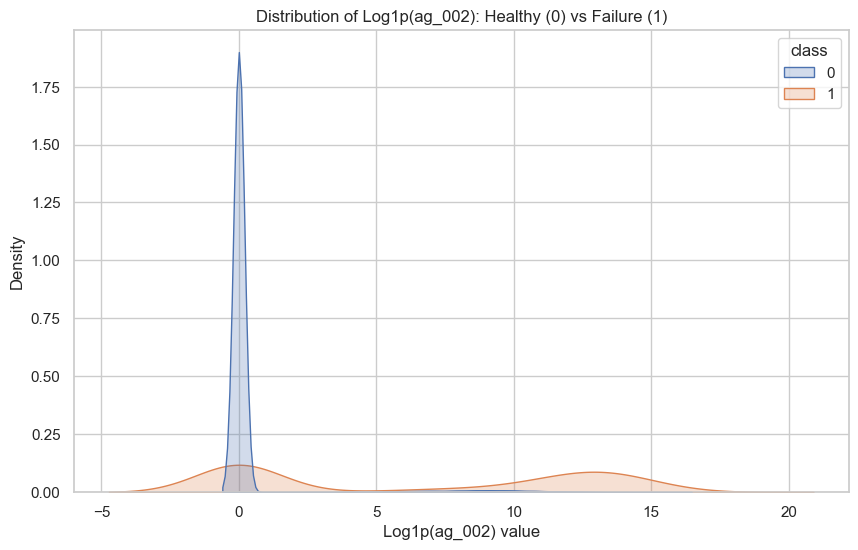


Descriptive Stats (Original Scale):
         count           mean            std  min  25%     50%       75%  \
class                                                                      
0      58915.0    1896.722329   56837.304871  0.0  0.0     0.0       0.0   
1       1000.0  398840.840000  998199.299191  0.0  0.0  1942.0  367493.0   

              max  
class              
0       7771682.0  
1      10552856.0  


In [64]:
analyze_feature_relationships(X_clean_filtered, y_clean_filtered, "ag_002")